In [109]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import os

In [110]:
from keras.utils import to_categorical

In [111]:
from keras.preprocessing.image import ImageDataGenerator

In [112]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [113]:
from keras.utils.vis_utils import plot_model
import itertools
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [26]:
#Access to my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Extract images file
!unzip gdrive/My\ Drive/skin_cancer/HAM10000_images.zip

Image path example : HAM10000_images/ISIC_0034013.jpg

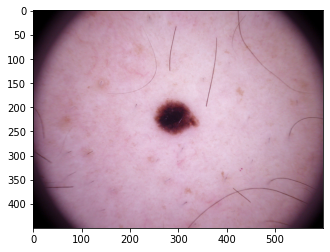

In [33]:
#Testing if images were properly extracted
id = 'HAM10000_images/ISIC_0034013.jpg'
img = cv2.imread(id)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Images metadata dataset preparation

In [54]:
#load images metadata file
df = pd.read_csv('HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [55]:
#build path for images
df['path'] = 'HAM10000_images/'+df['image_id']+'.jpg'
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images/ISIC_0031633.jpg


In [58]:
#coding skin cancer types
coding_dict = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
df['cancer_type_id'] = df['dx'].replace(coding_dict)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cancer_type_id
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0027419.jpg,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0025030.jpg,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0026769.jpg,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images/ISIC_0025661.jpg,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images/ISIC_0031633.jpg,2


In [77]:
#loading images to dataset and resizing them in order to allow the smooth and less processing time for the size of this much image data.
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [81]:
#dropping unnecessary columns, and separating target variable from dataset inn order to create train and test datasets
features = df.drop(columns=['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'path', 'cancer_type_id'],axis=1)
target = df['cancer_type_id']
print(features.shape)
print(target.shape)
#shape of images that have been resized
df['image'].map(lambda x: x.shape).value_counts()

(10015, 1)
(10015,)


(75, 100, 3)    10015
Name: image, dtype: int64

## Splitting dataset

In [91]:
#splitting data, 80% train and 20% test, with a seed = 2023 for reproducibility
x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(features, target, test_size=0.2,random_state=2023)

## Normalizing images

In [87]:
x_train = np.asarray(x_train_i['image'].tolist())
x_test = np.asarray(x_test_i['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

## Data augmentation

In [89]:
data_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
data_gen.fit(x_train)

## One hot encoding the labels

In [93]:
y_train = to_categorical(y_train_i)
y_test = to_categorical(y_test_i)

## Splitting into training and validation set

In [94]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2022)

## Building the Model

In [105]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (75, 100, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 7, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 73, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 47, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 25024)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

## Compile the model


In [106]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Fitting the model

In [107]:
epochs = 50
batch_size = 10
history = model.fit_generator(data_gen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1)

Epoch 1/50


<ipython-input-107-d1286238ca6e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_gen.flow(x_train,y_train, batch_size=batch_size),


641/641 [==============================] - 115s 177ms/step - loss: 0.9676 - accuracy: 0.6720 - val_loss: 0.9279 - val_accuracy: 0.6868
Epoch 2/50
641/641 [==============================] - 116s 181ms/step - loss: 0.8180 - accuracy: 0.7020 - val_loss: 0.8193 - val_accuracy: 0.7068
Epoch 3/50
641/641 [==============================] - 119s 186ms/step - loss: 0.7643 - accuracy: 0.7216 - val_loss: 0.7466 - val_accuracy: 0.7261
Epoch 4/50
641/641 [==============================] - 124s 193ms/step - loss: 0.7313 - accuracy: 0.7296 - val_loss: 0.7411 - val_accuracy: 0.7342
Epoch 5/50
641/641 [==============================] - 111s 174ms/step - loss: 0.6999 - accuracy: 0.7419 - val_loss: 0.7366 - val_accuracy: 0.7268
Epoch 6/50
641/641 [==============================] - 109s 169ms/step - loss: 0.6643 - accuracy: 0.7552 - val_loss: 0.7379 - val_accuracy: 0.7380
Epoch 7/50
641/641 [==============================] - 108s 168ms/step - loss: 0.6424 - accuracy: 0.7600 - val_loss: 0.7339 - val_accura

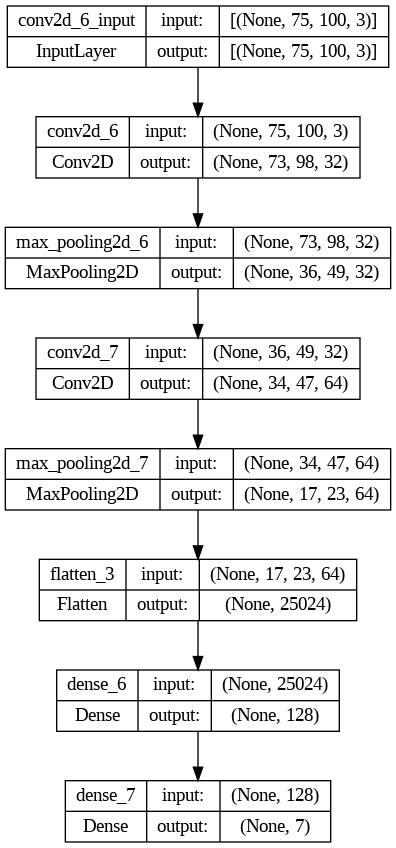

In [114]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [115]:
#Accuracy of the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

51/51 [==============================] - 5s 90ms/step - loss: 1.7726 - accuracy: 0.7080
Validation: accuracy = 0.708047  ;  loss_v = 1.772576
Test: accuracy = 0.728407  ;  loss = 1.459675


In [116]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



51/51 [==============================] - 5s 91ms/step


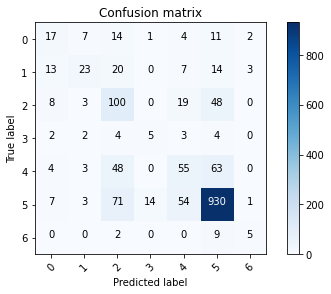

In [117]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

# Note:

The aim of this project was to gain familiarity with the techniques necessary to perform image classification and to develop a better understanding of the issue of skin cancer. However, there is significant room for improvement in this work, and future efforts should consider implementing the following steps:

- Incorporate a stage for optimizing hyperparameters to improve model performance.
- Enhance data augmentation techniques to increase the diversity and quality of the dataset.
- Due to class imbalance in the dataset, utilize F1 score instead of accuracy to evaluate model performance.
- Apply various cross-validation techniques to ensure that the model is robust and generalizes well.